# Imports

In [1]:
# imports
import numpy as np
import torch
from tueplots import bundles, figsizes
import wandb
import matplotlib.pyplot as plt

import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [2]:
from analysis import sweep2df, RED, BLUE, plot_typography


In [3]:
USETEX = True

In [4]:
plt.rcParams.update(bundles.neurips2022(usetex=USETEX))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

In [5]:
plot_typography(usetex=USETEX, small=12, medium=16, big=20)

In [6]:
# Constants
ENTITY = "causal-representation-learning"
PROJECT = "sam_test"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

In [40]:
SWEEP_ID = "e0geelo2" #"qqqqlma7"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sam_vae_{SWEEP_ID}"
df_sam_vae, sam_val_loss, sam_val_scale_inv = sweep2df(sweep.runs, filename, save=True, load=False)

ValueError: zero-size array to reduction operation minimum which has no identity

In [18]:
SWEEP_ID = "4aggfh82"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"fix_enc_var_sweep_{SWEEP_ID}"
df_fix_enc_var, fix_enc_val_loss, fix_enc_val_scale_inv = sweep2df(sweep.runs, filename, save=True, load=False)

In [97]:
SWEEP_ID = "v5jhcv20" #"1agmyttm"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"rae_sweep_{SWEEP_ID}"
df_rae, rae_val_loss, rae_val_scale_inv = sweep2df(sweep.runs, filename, save=True, load=False)

ValueError: zero-size array to reduction operation minimum which has no identity

# Pre-processing


In [20]:
enc_vars = df_fix_enc_var.enc_var.unique()


## SAM and VAE sanity check

In [ ]:
scale_no_sam = sam_val_scale_inv[ df_sam_vae.sam_update ==False]
scale_sam = sam_val_loss[df_sam_vae.sam_update ==True]

## Fix encoder variance

In [21]:
scale_enc_var_no_sam = {var: fix_enc_val_scale_inv[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
scale_enc_var_sam = {var: fix_enc_val_scale_inv[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

loss_enc_var_no_sam = {var: fix_enc_val_loss[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
loss_enc_var_sam = {var: fix_enc_val_loss[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

## RAE

In [ ]:
scale_rae = {var: rae_val_scale_inv[df_rae.enc_var == var] for var in enc_vars}
loss_rae = {var: rae_val_loss[df_rae.enc_var == var] for var in enc_vars}

# Plots

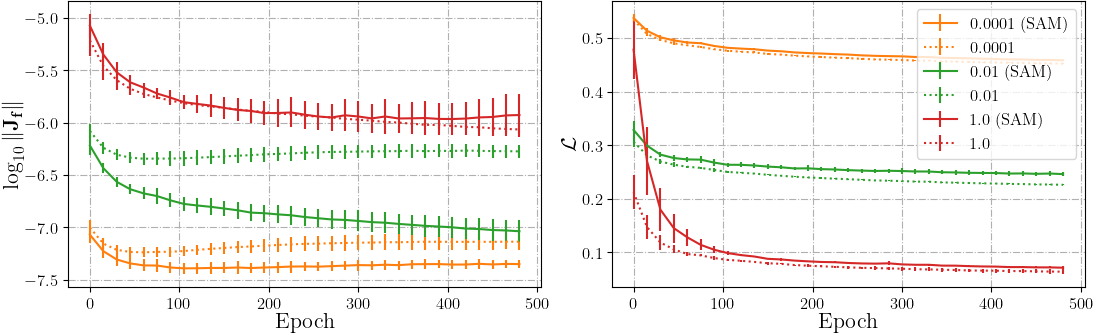

In [38]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(121)
ax.grid(True, which="both", ls="-.")



for (var, inv_scale_sam), inv_scale_no_sam, color in zip(scale_enc_var_sam.items(),scale_enc_var_no_sam.values(), COLORS):
    if len(inv_scale_sam) > 0:
        val_epoch_ticks = range(0, len(inv_scale_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_sam).mean(0), np.log10(inv_scale_sam).std(0), c=color, label=f"{var} (SAM)", ls="-")
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_no_sam).mean(0), np.log10(inv_scale_no_sam).std(0), c=color, label=str(var), ls=":")


ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)


ax = fig.add_subplot(122)
ax.grid(True, which="both", ls="-.")

for (var, loss_sam), loss_no_sam, color in zip(loss_enc_var_sam.items(), loss_enc_var_no_sam.values(), COLORS):
    if len(loss_sam) > 0:
        val_epoch_ticks = range(0, len(loss_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, loss_sam.mean(0), loss_sam.std(0), c=color, label=f"{var} (SAM)", ls="-")
        ax.errorbar(val_epoch_ticks, loss_no_sam.mean(0), loss_no_sam.std(0), c=color, label=str(var), ls=":")



ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)


plt.legend(loc="upper right")
plt.savefig("loss_grad_fix_enc_var.svg")